# Visualizations

Load probe evaluation artifacts (`.npz`) from `evaluate_probe.py` and visualize:
- Distance/depth probe performance across layers (Pearson, R²) with train/test colors (blue/red).
- Per-example probe scores vs. model partial accuracy.
- True vs. predicted distance/depth scatterplots by split.
- Split composition by example depth.
- Projected embeddings in probe space by depth and split.

Note: if probes were trained with PCA preprocessing, both distance and depth probes operate on the PCA-projected embeddings.


In [17]:
# Parameters
from pathlib import Path

NORMALIZED = False  # set True to load normalized-distance results
DEPTH_RANGE = [1, 2]
STEPS_RANGE = [1, 2]
NUM_SAMPLES = 1000

def _parse_range(values, name: str, min_value: int = 1) -> tuple[int, int]:
    if isinstance(values, (int, float)):
        values = [int(values)]
    if len(values) == 1:
        range_min = range_max = int(values[0])
    elif len(values) == 2:
        range_min, range_max = [int(v) for v in values]
    else:
        raise ValueError(f"{name} must have 1 or 2 integers")
    if range_min < min_value or range_max < min_value or range_max < range_min:
        raise ValueError(f"{name} must be >= {min_value} and max >= min")
    return range_min, range_max


def _format_steps_tag(num_steps) -> str:
    if isinstance(num_steps, (list, tuple)):
        if len(num_steps) != 2:
            raise ValueError("num_steps must have 1 or 2 integers")
        min_steps, max_steps = num_steps
    else:
        min_steps = max_steps = int(num_steps)
    if min_steps == max_steps == 1:
        return ""
    if min_steps == max_steps:
        return f"_steps{min_steps}"
    return f"_steps{min_steps}-{max_steps}"


def _dataset_tag(min_depth: int, max_depth: int, num_samples: int, num_steps) -> str:
    suffix = f"n{num_samples}" if num_samples > 0 else "nall"
    steps = _format_steps_tag(num_steps)
    return f"depth{min_depth}-{max_depth}_{suffix}{steps}"


MIN_DEPTH, MAX_DEPTH = _parse_range(DEPTH_RANGE, "depth-range", min_value=1)
MIN_STEPS, MAX_STEPS = _parse_range(STEPS_RANGE, "steps-range", min_value=1)
STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
DATASET_TAG = _dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)
MODEL_TAG = "DeepSeek-R1-Distill-Qwen-14B"
PROJ_DIM = 5
PCA_COMPONENTS = 10
LAYER = 31  # Layer to use for per-example stats, true vs predicted, and tree reconstruction plots

norm_suffix = "_normtree" if NORMALIZED else ""
RESULTS_PATH = Path(f"../data/{DATASET_TAG}/models/{MODEL_TAG}/probes/probe{norm_suffix}_proj{PROJ_DIM}_pca{PCA_COMPONENTS}.npz")

In [18]:
import json
import sys
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize

NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / "cutter").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise RuntimeError("Could not locate repository root containing cutter/")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from cutter.utils.tree.probing import pairwise_distance, transform_probe_space, fit_depth_probe, fit_distance_probe

from cutter.utils.tree.encoding import DEVICE
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
sns.set_theme(style="whitegrid")
SPLIT_PALETTE = {
    "train": "#1f77b4",
    "test": "#d62728",
    "test_exact": "#2ca02c",
    "test_inexact": "#fca5a5",
}

if not RESULTS_PATH.exists():
    raise FileNotFoundError(f"Probe results not found: {RESULTS_PATH}")

artifact = np.load(RESULTS_PATH, allow_pickle=True)
meta = artifact["meta"].item()
encodings = artifact["encodings"].item()
results = artifact["results"].item()

def _pca_transform(features: np.ndarray, res: dict) -> np.ndarray:
    pca = res.get("pca") if isinstance(res, dict) else None
    if not pca:
        return features
    components = np.asarray(pca.get("components", []), dtype=np.float32)
    mean = np.asarray(pca.get("mean", 0.0), dtype=np.float32)
    if components.size == 0:
        return features
    if features.shape[1] == components.shape[0]:
        return features
    return (features - mean) @ components.T


def _resolve_probe_projection(res: dict) -> np.ndarray:
    if isinstance(res, dict) and isinstance(res.get("distance"), dict) and res["distance"].get("projection") is not None:
        return res["distance"]["projection"]
    if isinstance(res, dict) and res.get("projection") is not None:
        return res["projection"]
    raise ValueError("No projection found in results for the requested layer.")


print("Loaded artifact with layers:", list(results.keys()))

Loaded artifact with layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [19]:
def _resolve_distance_probe(layer: int, res: dict, data: dict, meta: dict):
    """Return (projection, info) for a layer, preferring saved probe weights."""
    res = res or {}
    if isinstance(res, dict):
        try:
            proj = _resolve_probe_projection(res)
        except Exception:
            proj = None
        if proj is not None:
            info = {
                "geometry": res.get("geometry", meta.get("fit_geometry", "euclidean")),
                "center": res.get("center"),
                "curvature": res.get("curvature"),
                "normalized_tree": res.get("normalized_tree", meta.get("normalize_tree", False)),
            }
            return proj, info
    # Refit using stored encodings if projection is missing
    from cutter.utils.tree.trees import DistanceProbeConfig
    from cutter.utils.tree.probing import fit_distance_probe
    X = data.get("X") if isinstance(data, dict) else None
    dist = data.get("dist") if isinstance(data, dict) else None
    train_idx = data.get("train_idx") if isinstance(data, dict) else None
    if X is None or dist is None or train_idx is None:
        raise RuntimeError("Encodings missing X/dist/train_idx; cannot recover projection")
    train_idx = np.asarray(train_idx, dtype=int)
    X_train = _pca_transform(np.asarray(X)[train_idx], res)
    dist_train = np.asarray(dist)[np.ix_(train_idx, train_idx)]
    cfg = DistanceProbeConfig(
        proj_dim=int(meta.get("proj_dim", 16)),
        steps=int(meta.get("steps", meta.get("probe_steps", 1500))),
        lr=float(meta.get("lr", 1e-2)),
        weight_decay=float(meta.get("weight_decay", 1e-4)),
        seed=int(meta.get("seed", meta.get("train_seed", 42))),
        fit_geometry=str(meta.get("fit_geometry", meta.get("geometry", "euclidean"))),
    )
    B, info = fit_distance_probe(X_train, dist_train, cfg, device=DEVICE)
    return B, info


def _resolve_depth_model(layer: int, res: dict, data: dict):
    """Return saved depth model and normalization factor if available."""
    depth_block = res.get("depth") if isinstance(res, dict) else {}
    model = None
    norm_factor = None
    if isinstance(depth_block, dict):
        model = depth_block.get("model") or res.get("depth_model")
        norm_factor = depth_block.get("normalization_factor") or res.get("normalization_factor")
        if norm_factor is None and depth_block.get("normalized_tree") and data.get("depth") is not None:
            # fallback: derive from max depth if not stored explicitly
            norm_factor = float(np.max(np.asarray(data.get("depth"))))
    return model, norm_factor

In [20]:
# Build metrics_df from the loaded results artifact
def _stat_or_value(res: dict, key: str):
    stats = res.get("stats", {}).get("dist", {})
    if key in stats:
        entry = stats.get(key, {})
        return float(entry.get("mean", float("nan"))), float(entry.get("std", float("nan")))
    val = res.get(key)
    return (float(val) if val is not None else float("nan")), float("nan")


def _depth_stat_or_value(res: dict, split: str, metric: str):
    stats = res.get("stats", {}).get("depth", {})
    if split in stats and metric in stats[split]:
        entry = stats[split][metric]
        return float(entry.get("mean", float("nan"))), float(entry.get("std", float("nan")))
    depth_block = res.get("depth", {}) if isinstance(res, dict) else {}
    split_data = depth_block.get(split, {}) if isinstance(depth_block, dict) else {}
    val = split_data.get(metric)
    return (float(val) if val is not None else float("nan")), float("nan")


# Build metrics_df from the loaded results artifact
def build_metrics_df(results: Dict[int, Any]) -> pd.DataFrame:
    """Build a DataFrame of layer-by-layer probe metrics from the results dict."""
    rows = []
    for layer, res in results.items():
        if not isinstance(res, dict):
            continue
        # Distance metrics
        for split in ["train", "test", "test_exact", "test_inexact", "shuf_train", "shuf_test"]:
            mse_key = f"dist_mse_{split}"
            corr_key = f"dist_corr_{split}"
            mse_val, mse_std = _stat_or_value(res, mse_key)
            corr_val, corr_std = _stat_or_value(res, corr_key)
            rows.append({
                "layer": layer,
                "metric": "distance",
                "split": split,
                "mse": mse_val,
                "mse_std": mse_std,
                "pearson": corr_val,
                "pearson_std": corr_std,
            })
        # Depth metrics
        for split in ["train", "test", "test_exact", "test_inexact", "shuf_train", "shuf_test"]:
            mse_val, mse_std = _depth_stat_or_value(res, split, "mse")
            pearson_val, pearson_std = _depth_stat_or_value(res, split, "pearson")
            rows.append({
                "layer": layer,
                "metric": "depth",
                "split": split,
                "mse": mse_val,
                "mse_std": mse_std,
                "pearson": pearson_val,
                "pearson_std": pearson_std,
            })
    return pd.DataFrame(rows)

metrics_df = build_metrics_df(results)
print("metrics_df rows:", len(metrics_df))

metrics_df rows: 588


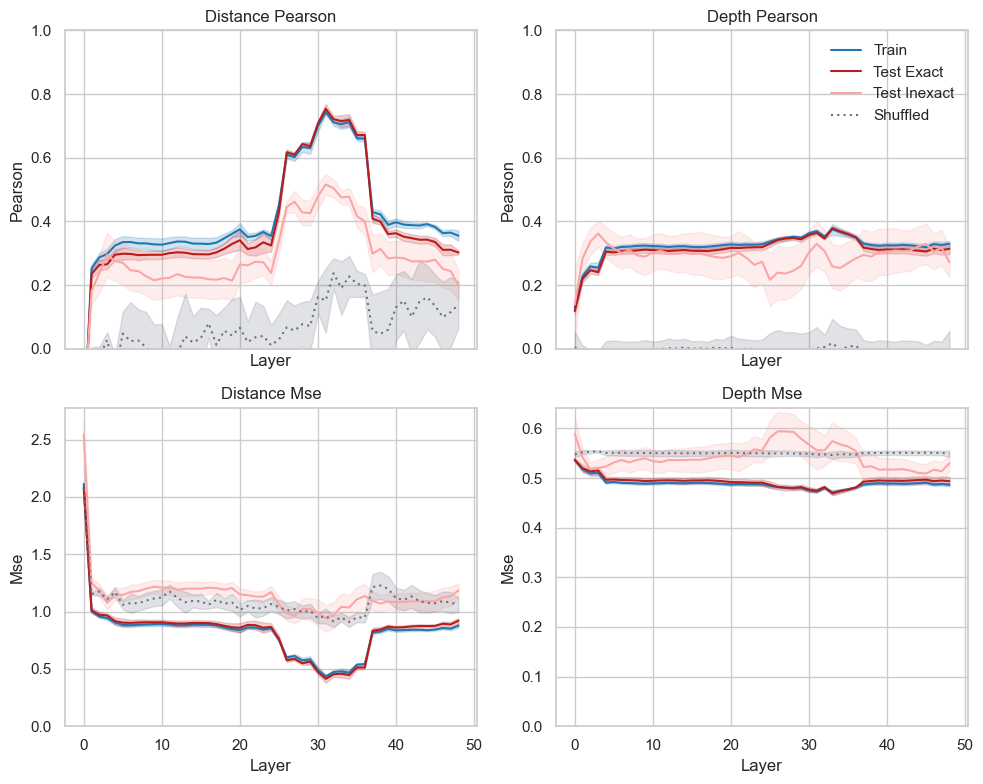

In [21]:
def plot_layer_curves(df: pd.DataFrame, save=False):
    # Two rows (Pearson, MSE) x two columns (distance, depth)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex="col")

    filtered_df = df[df.split.isin(["train", "test_exact", "test_inexact", "shuf_train"])]
    custom_palette = {
        "train": "#1f77b4",  # blue
        "test_exact": "#b91c1c",  # darker red (more saturated)
        "test_inexact": "#fca5a5",  # lighter red (softer)
        "shuf_train": "#6b7280",  # gray baseline
    }
    dashes_mapping = {
        "train": (),
        "test_exact": (),
        "test_inexact": (),
        "shuf_train": (1, 2),
    }
    hue_order = ["train", "test_exact", "test_inexact", "shuf_train"]
    
    # Mapping for legend labels
    label_mapping = {
        "train": "Train",
        "test_exact": "Test Exact",
        "test_inexact": "Test Inexact",
        "shuf_train": "Shuffled",
    }

    rows = [
        ("pearson", (0, 1)),  # Pearson row with y in [0, 1]
        ("mse", (0, None)),
    ]
    metrics = ["distance", "depth"]

    for row_idx, (score_col, ylim) in enumerate(rows):
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]
            for split in hue_order:
                subset = filtered_df[(filtered_df.metric == metric) & (filtered_df.split == split)].sort_values("layer")
                if subset.empty:
                    continue
                x = subset["layer"].to_numpy()
                y = subset[score_col].to_numpy()
                std_col = f"{score_col}_std"
                y_std = subset[std_col].to_numpy() if std_col in subset else np.full_like(y, np.nan, dtype=float)
                y_std = np.where(np.isfinite(y_std), y_std, 0.0)
                ax.plot(
                    x,
                    y,
                    color=custom_palette.get(split, "#1f77b4"),
                    label=label_mapping.get(split, split),
                    dashes=dashes_mapping.get(split, ()),
                )
                if np.any(y_std > 0):
                    ax.fill_between(
                        x,
                        y - y_std,
                        y + y_std,
                        color=custom_palette.get(split, "#1f77b4"),
                        alpha=0.2,
                    )

            ax.set_ylim(ylim)
            ax.set_title(f"{metric.title()} {score_col.title()}")
            ax.set_xlabel("Layer")
            ax.set_ylabel(score_col.title())

    handles, labels = axes[0, 0].get_legend_handles_labels()
    axes[0, 1].legend(handles, labels, loc="upper right", frameon=False)
    plt.tight_layout()
    if save:
        fig.savefig("probe_layer_curves.png", dpi=300)
    plt.show()

plot_layer_curves(metrics_df)

In [22]:
# Rebuild full encodings (X/dist) if saved artifact is lightweight
from cutter.scripts.evaluate_probe import load_embedding_cache
from cutter.utils.tree.trees import tree_distance, DistanceProbeConfig
from cutter.utils.shared.paths import embeddings_path as default_embeddings_path


def _locate_embeddings(meta: dict, results_path: Path, project_root: Path) -> Path:
    candidates = []
    meta_path = meta.get("embeddings_path")
    if meta_path:
        p = Path(meta_path)
        candidates.append(p)
        if not p.is_absolute():
            candidates.append(project_root / p)
    # probe path: ../models/<model>/probes/probe_*.npz -> sibling embeddings.npz
    candidates.append(results_path.parent.parent / "embeddings.npz")
    dataset_tag = meta.get("dataset_tag")
    model_id = meta.get("model")
    if dataset_tag and model_id:
        try:
            candidates.append(default_embeddings_path(dataset_tag, model_id))
        except Exception:
            pass
    for cand in candidates:
        if cand and Path(cand).exists():
            return Path(cand)
    return Path()


def _rebuild_layer_encoding(layer: int, data: dict, meta: dict, results_path: Path, project_root: Path) -> dict:
    """Rebuild X and dist for a single layer only."""
    # If already has X/dist, return as-is
    if isinstance(data, dict) and "X" in data and "dist" in data:
        return data
    
    emb_path = _locate_embeddings(meta, results_path, project_root)
    cache = load_embedding_cache(emb_path) if emb_path.exists() else None
    if cache is None:
        raise RuntimeError(f"Cannot rebuild encodings without embeddings cache. Tried: {emb_path}")
    
    example_ids = np.asarray(data.get("example_ids", []), dtype=int)
    node_ids = np.asarray(data.get("node_ids", []), dtype=int)
    depths = np.asarray(data.get("depth", []), dtype=float)
    blocks = []
    idx = 0
    # Reconstitute X by grouping contiguous rows per example id.
    while idx < len(example_ids):
        ex_id = int(example_ids[idx])
        count = 1
        while idx + count < len(example_ids) and example_ids[idx + count] == ex_id:
            count += 1
        rec = cache.get(ex_id)
        if rec is None:
            raise KeyError(f"Missing embedding cache entry for example {ex_id}")
        emb_layer = rec.get("embeddings_by_layer", {}).get(layer) if isinstance(rec, dict) else getattr(rec, "embeddings_by_layer", {}).get(layer)
        if emb_layer is None:
            raise KeyError(f"No embeddings for layer {layer} in example {ex_id}")
        block = np.asarray(emb_layer, dtype=np.float32)[:count]
        if block.shape[0] != count:
            raise ValueError(f"Embedding rows {block.shape[0]} do not match expected count {count} for example {ex_id}")
        blocks.append(block)
        idx += count
    X = np.vstack(blocks) if blocks else np.empty((0, 0), dtype=np.float32)
    n = len(node_ids)
    dist = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = float(tree_distance(int(node_ids[i]), int(node_ids[j])))
    return {**data, "X": X, "dist": dist}


# Only rebuild the specified layer if it's missing X or dist
layer_data = encodings.get(LAYER, {})
needs_rebuild = not (isinstance(layer_data, dict) and "X" in layer_data and "dist" in layer_data)
if needs_rebuild:
    encodings[LAYER] = _rebuild_layer_encoding(LAYER, layer_data, meta, RESULTS_PATH, PROJECT_ROOT)
    print(f"Rebuilt encodings for layer {LAYER} from embeddings cache.")
else:
    print(f"Layer {LAYER} already contains X/dist; skipping rebuild.")

Rebuilt encodings for layer 31 from embeddings cache.


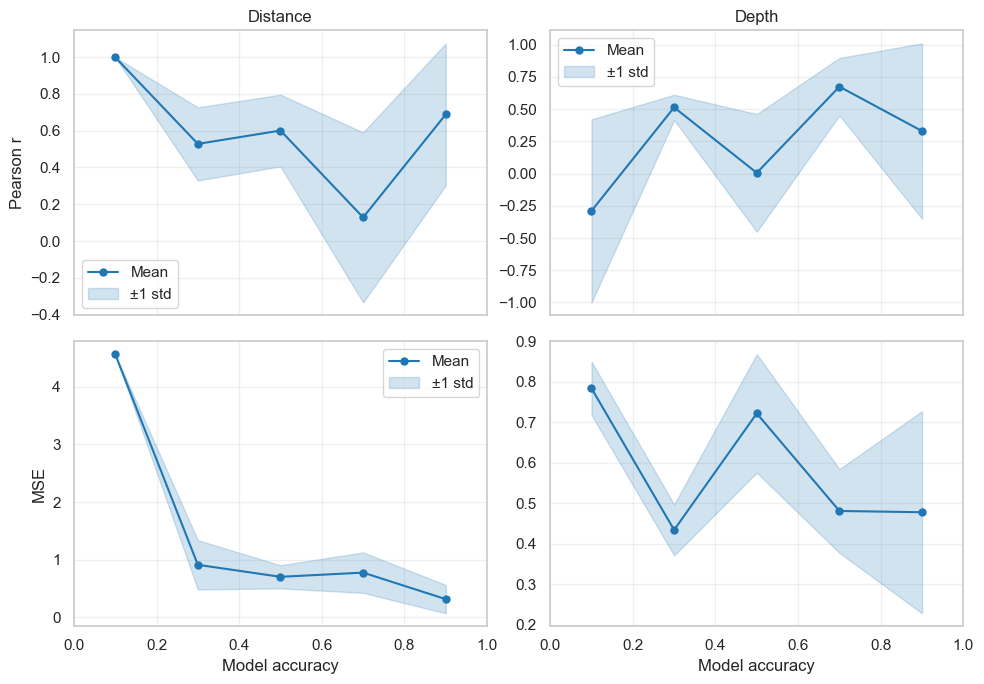

In [23]:
# Per-example averages vs partial model accuracy
def _fit_depth_linear(features: np.ndarray, targets: np.ndarray, alpha: float = 1e-2):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("reg", Ridge(alpha=alpha)),
    ])
    return model.fit(features, targets)

def per_example_scores(encodings: Dict[int, Any], results: Dict[int, Any], meta: Dict[str, Any]) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for layer, data in (encodings or {}).items():
        res = results.get(layer, {}) if isinstance(results, dict) else {}
        X = data.get("X") if isinstance(data, dict) else None
        depths = data.get("depth") if isinstance(data, dict) else None
        dist_true = data.get("dist") if isinstance(data, dict) else None
        example_ids = data.get("example_ids") if isinstance(data, dict) else None
        example_acc = data.get("example_accuracy") if isinstance(data, dict) else None
        train_idx = set(data.get("train_idx", [])) if isinstance(data, dict) else set()
        if X is None or dist_true is None or example_ids is None:
            continue
        try:
            B, info = _resolve_distance_probe(layer, res, data, meta)
        except Exception as exc:
            print(f"Skipping layer {layer} (cannot resolve projection: {exc})")
            continue
        geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))
        center = info.get("center")
        curvature = info.get("curvature")
        X_feat = _pca_transform(np.asarray(X), res)
        Z = X_feat @ np.asarray(B)
        if geometry == "hyperbolic":
            Z = transform_probe_space(Z, info)
        dist_pred = pairwise_distance(Z, geometry, center=center, curvature=curvature)
        depth_model, depth_norm = _resolve_depth_model(layer, res, data)
        depths_eval = np.asarray(depths) / depth_norm if depth_norm else np.asarray(depths)
        X_raw = _pca_transform(np.asarray(X), res)
        if depth_model is None:
            depth_model = _fit_depth_linear(X_raw[list(train_idx)], depths_eval[list(train_idx)]) if train_idx else None
        depth_pred = depth_model.predict(X_raw) if depth_model is not None else np.zeros_like(depths_eval)
        example_ids_arr = np.asarray(example_ids)
        for ex_id in np.unique(example_ids_arr):
            mask = example_ids_arr == ex_id
            split = "train" if any(idx in train_idx for idx, flag in enumerate(mask) if flag) else "test"
            acc = float(np.asarray(example_acc)[mask][0]) if example_acc is not None else np.nan
            idxs = np.where(mask)[0]
            if idxs.size < 2:
                continue
            tri = np.triu_indices(idxs.size, k=1)
            true_sub = dist_true[np.ix_(idxs, idxs)][tri]
            pred_sub = dist_pred[np.ix_(idxs, idxs)][tri]
            pearson_dist = np.corrcoef(true_sub, pred_sub)[0, 1] if true_sub.size > 1 else np.nan
            mse_dist = np.mean((true_sub - pred_sub) ** 2) if true_sub.size > 1 else np.nan
            true_depth = depths_eval[idxs]
            pred_depth = depth_pred[idxs]
            pearson_depth = np.corrcoef(true_depth, pred_depth)[0, 1] if true_depth.size > 1 else np.nan
            mse_depth = np.mean((true_depth - pred_depth) ** 2) if true_depth.size > 1 else np.nan
            rows.append(
                {
                    "layer": layer,
                    "split": split,
                    "example_id": int(ex_id),
                    "model_accuracy": acc,
                    "dist_pearson": pearson_dist,
                    "dist_mse": mse_dist,
                    "depth_pearson": pearson_depth,
                    "depth_mse": mse_depth,
                }
            )
    return pd.DataFrame(rows)

per_example_df = per_example_scores(encodings, results, meta)
per_example_df = per_example_df[(per_example_df["split"] == "test") & (per_example_df["layer"] == LAYER)]

def binned_avg_std_pearson(x: np.ndarray, y: np.ndarray, nbins: int = 10, xlim=(0, 1)):
    """Bin x, aggregate y by mean/std per bin. Returns bin centers, mean, std (NaN bins filtered out)."""
    bins = np.linspace(xlim[0], xlim[1], nbins + 1)
    digitized = np.digitize(x, bins) - 1
    digitized = np.clip(digitized, 0, nbins - 1)  # Handle edge cases
    bin_centers = (bins[:-1] + bins[1:]) / 2
    y_mean = np.array([y[digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(nbins)])
    y_std = np.array([y[digitized == i].std() if np.any(digitized == i) else np.nan for i in range(nbins)])
    # Filter out bins with NaN values so fill_between can propagate continuously
    valid = ~np.isnan(y_mean)
    return bin_centers[valid], y_mean[valid], y_std[valid]

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex="col")

x_dist = per_example_df["model_accuracy"].values
x_depth = per_example_df["model_accuracy"].values

# Distance Pearson vs accuracy (top-left)
y_dist_pearson = per_example_df["dist_pearson"].values
valid_dist_pearson = ~np.isnan(y_dist_pearson)
bin_centers, y_mean, y_std = binned_avg_std_pearson(
    x_dist[valid_dist_pearson],
    y_dist_pearson[valid_dist_pearson],
    nbins=5,
)
axes[0, 0].plot(bin_centers, y_mean, "o-", color="#1f77b4", markersize=5, label="Mean")
axes[0, 0].fill_between(
    bin_centers,
    y_mean - y_std,
    y_mean + y_std,
    color="#1f77b4",
    alpha=0.2,
    label="±1 std",
)
axes[0, 0].set_title("Distance")
axes[0, 0].set_ylabel("Pearson r")
axes[0, 0].set_xlim(0, 1)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Depth Pearson vs accuracy (top-right)
y_depth_pearson = per_example_df["depth_pearson"].values
valid_depth_pearson = ~np.isnan(y_depth_pearson)
bin_centers, y_mean, y_std = binned_avg_std_pearson(
    x_depth[valid_depth_pearson],
    y_depth_pearson[valid_depth_pearson],
    nbins=5,
)
axes[0, 1].plot(bin_centers, y_mean, "o-", color="#1f77b4", markersize=5, label="Mean")
axes[0, 1].fill_between(
    bin_centers,
    y_mean - y_std,
    y_mean + y_std,
    color="#1f77b4",
    alpha=0.2,
    label="±1 std",
)
axes[0, 1].set_title("Depth")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Distance MSE vs accuracy (bottom-left)
y_dist_mse = per_example_df["dist_mse"].values
valid_dist_mse = ~np.isnan(y_dist_mse)
bin_centers, y_mean, y_std = binned_avg_std_pearson(x_dist[valid_dist_mse], y_dist_mse[valid_dist_mse], nbins=5)
axes[1, 0].plot(bin_centers, y_mean, "o-", color="#1f77b4", markersize=5, label="Mean")
axes[1, 0].fill_between(bin_centers, y_mean - y_std, y_mean + y_std, color="#1f77b4", alpha=0.2, label="±1 std")
axes[1, 0].set_xlabel("Model accuracy")
axes[1, 0].set_ylabel("MSE")
axes[1, 0].set_xlim(0, 1)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Depth MSE vs accuracy (bottom-right)
y_depth_mse = per_example_df["depth_mse"].values
valid_depth_mse = ~np.isnan(y_depth_mse)
bin_centers, y_mean, y_std = binned_avg_std_pearson(x_depth[valid_depth_mse], y_depth_mse[valid_depth_mse], nbins=5)
axes[1, 1].plot(bin_centers, y_mean, "o-", color="#1f77b4", markersize=5, label="Mean")
axes[1, 1].fill_between(bin_centers, y_mean - y_std, y_mean + y_std, color="#1f77b4", alpha=0.2, label="±1 std")
axes[1, 1].set_xlabel("Model accuracy")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "cutter/figures/final/accuracy-vs-mse.png", dpi=300)

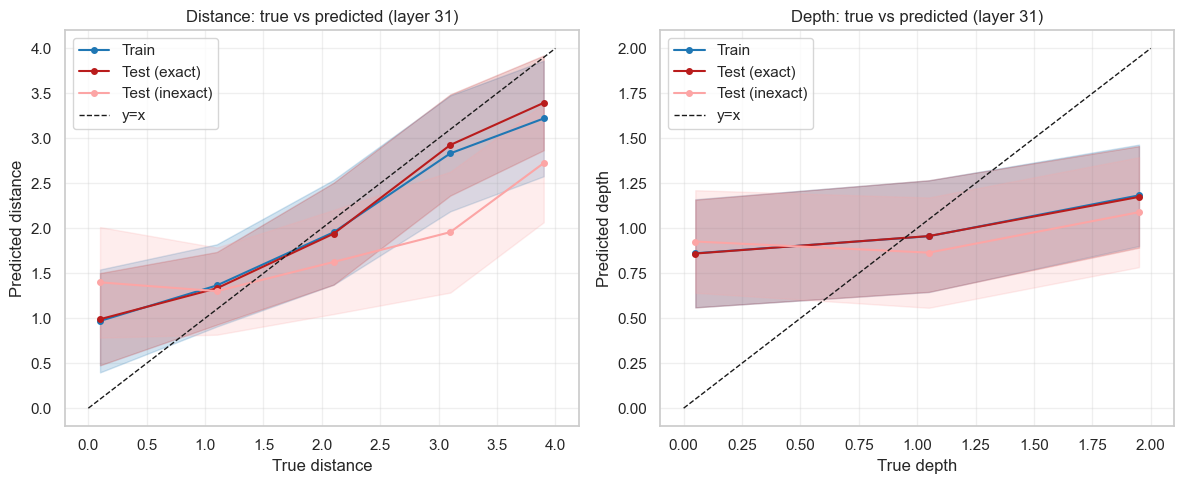

In [24]:
# Average and std fill_between: true vs predicted distance and depth as function of true
def binned_avg_std(x: np.ndarray, y: np.ndarray, nbins: int = 20, xlim=None):
    """Bin x, aggregate y by mean/std per bin. Returns bin centers, mean, std (NaN bins filtered out)."""
    if xlim is None:
        xlim = (x.min(), x.max())
    bins = np.linspace(xlim[0], xlim[1], nbins+1)
    digitized = np.digitize(x, bins) - 1
    digitized = np.clip(digitized, 0, nbins - 1)  # Handle edge cases
    bin_centers = (bins[:-1] + bins[1:]) / 2
    y_mean = np.array([y[digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(nbins)])
    y_std = np.array([y[digitized == i].std() if np.any(digitized == i) else np.nan for i in range(nbins)])
    counts = np.array([np.sum(digitized == i) for i in range(nbins)])
    # Filter out bins with NaN values so fill_between can propagate continuously
    valid = ~np.isnan(y_mean)
    return bin_centers[valid], y_mean[valid], y_std[valid], counts[valid]


def plot_dist_avg_std(encodings: Dict[int, Any], results: Dict[int, Any], layer: int, title_prefix: str, meta: Dict[str, Any], nbins: int = 20, responses_path: Path = None):
    data = encodings[layer]
    res = results.get(layer, {}) if isinstance(results, dict) else {}
    X = data.get("X") if isinstance(data, dict) else None
    depths = data.get("depth") if isinstance(data, dict) else None
    dist_true = data.get("dist") if isinstance(data, dict) else None
    train_idx = set(data.get("train_idx", [])) if isinstance(data, dict) else set()
    if X is None or dist_true is None:
        print(f"Skipping layer {layer}: encodings missing X/dist")
        return
    try:
        B, info = _resolve_distance_probe(layer, res, data, meta)
    except Exception as exc:
        print(f"Skipping layer {layer} (cannot resolve projection: {exc})")
        return
    
    # Check if normalization was used and normalize true values to match
    is_normalized = meta.get("normalize_tree", False) or info.get("normalized_tree", False)
    if is_normalized:
        # Compute max_tree_depth from the data (same as used during training)
        max_tree_depth = float(np.max(depths)) if depths is not None else 1.0
        # Normalize true values to match the normalized space the probe was trained on
        dist_true = dist_true / max_tree_depth
        depths = depths / max_tree_depth
    
    geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))
    center = info.get("center")
    curvature = info.get("curvature")
    X_feat = _pca_transform(np.asarray(X), res)
    Z = X_feat @ np.asarray(B)
    if geometry == "hyperbolic":
        Z = transform_probe_space(Z, info)
    dist_pred = pairwise_distance(Z, geometry, center=center, curvature=curvature)
    example_ids = np.asarray(data.get("example_ids", []))
    test_idx = set(data.get("test_idx", [])) if isinstance(data, dict) else set()
    tri = np.triu_indices_from(dist_true, k=1)
    i_idx, j_idx = tri
    if example_ids.size:
        same_example = example_ids[i_idx] == example_ids[j_idx]
    else:
        same_example = np.zeros_like(i_idx, dtype=bool)
    is_train = np.array([i in train_idx and j in train_idx for i, j in zip(i_idx, j_idx)]) & same_example
    is_test = np.array([i in test_idx and j in test_idx for i, j in zip(i_idx, j_idx)]) & same_example

    # Load exact_match information if responses_path is provided
    exact_match_map = {}
    if responses_path and Path(responses_path).exists():
        with open(responses_path) as f:
            for line in f:
                rec = json.loads(line)
                ex_id = rec.get("example_id")
                if ex_id is not None:
                    exact_match_map[ex_id] = rec.get("exact_match", False)
    
    # Map indices to example_ids and determine test_exact vs test_inexact
    example_ids = np.asarray(data.get("example_ids", []))
    is_exact = np.array([exact_match_map.get(int(ex_id), False) for ex_id in example_ids])
    
    # For distance pairs: test_exact if both examples are exact_match, test_inexact otherwise
    is_test_exact_dist = np.array([
        is_test[k] and is_exact[i] and is_exact[j] 
        for k, (i, j) in enumerate(zip(*tri))
    ])
    is_test_inexact_dist = is_test & ~is_test_exact_dist
    
    # For depth: test_exact if exact_match, test_inexact otherwise
    is_test_exact_depth = np.array([i in test_idx and is_exact[i] for i in range(len(depths))])
    is_test_inexact_depth = np.array([i in test_idx and not is_exact[i] for i in range(len(depths))])

    # Custom palette matching other plots
    custom_palette = {
        "train": "#1f77b4",  # blue
        "test_exact": "#b91c1c",  # darker red (more saturated)
        "test_inexact": "#fca5a5",  # lighter red (softer)
    }

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Distances: true vs predicted (train, test_exact, test_inexact)
    ax_dist = axes[0]
    xlim_dist = None
    for split, mask, color, label in [
        ("train", is_train, custom_palette["train"], "Train"),
        ("test_exact", is_test_exact_dist, custom_palette["test_exact"], "Test (exact)"),
        ("test_inexact", is_test_inexact_dist, custom_palette["test_inexact"], "Test (inexact)"),
    ]:
        if mask.sum() == 0:
            continue
        x = dist_true[tri][mask]
        y = dist_pred[tri][mask]
        bin_centers, y_mean, y_std, counts = binned_avg_std(x, y, nbins=nbins)
        if xlim_dist is None:
            xlim_dist = (x.min(), x.max())
        ax_dist.plot(bin_centers, y_mean, 'o-', color=color, label=f"{label}", markersize=4)
        ax_dist.fill_between(bin_centers, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)
    if xlim_dist is None:
        xlim_dist = (0, 1)
    ax_dist.plot([xlim_dist[0], xlim_dist[1]], [xlim_dist[0], xlim_dist[1]], 'k--', linewidth=1, label="y=x")
    ax_dist.set_xlabel("True distance" + (" (normalized)" if is_normalized else ""))
    ax_dist.set_ylabel("Predicted distance" + (" (normalized)" if is_normalized else ""))
    ax_dist.set_title(f"Distance: true vs predicted (layer {layer})")
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3)

    # Depths: true vs predicted (train, test_exact, test_inexact)
    ax_depth = axes[1]
    depth_model, depth_norm = _resolve_depth_model(layer, res, data)
    depths_eval = depths / depth_norm if depth_norm else depths
    X_raw = _pca_transform(np.asarray(X), res)
    if depth_model is None and train_idx:
        depth_model = _fit_depth_linear(X_raw[list(train_idx)], np.asarray(depths_eval)[list(train_idx)])
    if depth_model is not None:
        depth_pred = depth_model.predict(X_raw)
        xlim_depth = None
        for split, mask, color, label in [
            ("train", np.array([i in train_idx for i in range(len(depths))]), custom_palette["train"], "Train"),
            ("test_exact", is_test_exact_depth, custom_palette["test_exact"], "Test (exact)"),
            ("test_inexact", is_test_inexact_depth, custom_palette["test_inexact"], "Test (inexact)"),
        ]:
            if mask.sum() == 0:
                continue
            x = np.asarray(depths_eval)[mask]
            y = depth_pred[mask]
            bin_centers, y_mean, y_std, counts = binned_avg_std(x, y, nbins=nbins)
            if xlim_depth is None:
                xlim_depth = (x.min(), x.max())
            ax_depth.plot(bin_centers, y_mean, 'o-', color=color, label=f"{label}", markersize=4)
            ax_depth.fill_between(bin_centers, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)
        if xlim_depth is None:
            xlim_depth = (0, 1)
        ax_depth.plot([xlim_depth[0], xlim_depth[1]], [xlim_depth[0], xlim_depth[1]], 'k--', linewidth=1, label="y=x")
        ax_depth.set_xlabel("True depth" + (" (normalized)" if is_normalized else ""))
        ax_depth.set_ylabel("Predicted depth" + (" (normalized)" if is_normalized else ""))
        ax_depth.set_title(f"Depth: true vs predicted (layer {layer})")
        ax_depth.legend()
        ax_depth.grid(True, alpha=0.3)
    else:
        ax_depth.text(0.5, 0.5, "No depth regression available", ha="center", va="center", transform=ax_depth.transAxes)
        ax_depth.set_title(f"Depth: true vs predicted (layer {layer})")
    
    plt.tight_layout()
    plt.show()

# Construct responses_path from RESULTS_PATH
responses_path = RESULTS_PATH.parent.parent / "responses.jsonl"
if not responses_path.exists():
    responses_path = None

plot_dist_avg_std(encodings, results, LAYER, "Distances: true vs pred", meta, responses_path=responses_path)